In [1]:
### CHANGE TO THE FILEPATH OF THE NLP PROJECT FOLDER
NLP_folder = '/content/drive/MyDrive/NLP Project'
n_datapoints = 1000000
possible_orders = ['original', 'reversed', 'random', 'ordered_sov', 'ordered_svo', 'ordered_osv', 'ordered_ovs', 'ordered_vso', 'ordered_vos']
# orders_to_run = possible_orders
orders_to_run = ['ordered_svo', 'ordered_vso', 'ordered_osv']
#, 'random', 'ordered_sov', 'ordered_svo', 'ordered_osv', ]
# orders_to_run = ['ordered_sov', 'ordered_svo']

num_epochs = 2


In [2]:
import torch
import numpy as np
import pandas as pd

# Load data (parsed by stanza) and train on reversed sentences

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install datasets
from datasets import load_dataset, Dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [6]:
import sys
sys.path.append(NLP_folder)
import data_processing_utils

# Load the JSON file
file_names = {
    'train': f'{NLP_folder}/datasets/{n_datapoints}/training_data_{n_datapoints}',
    'val': f'{NLP_folder}/datasets/{n_datapoints}/validation_data_{n_datapoints}',
    'test': f'{NLP_folder}/datasets/{n_datapoints}/testing_data_{n_datapoints}'
}
train_data = data_processing_utils.load_from_json_file(file_names['train'])
val_data = data_processing_utils.load_from_json_file(file_names['val'])
test_data = data_processing_utils.load_from_json_file(file_names['test'])

print(f"{data_processing_utils.get_shuffled_strings(train_data[0 : 1])=}")

data_processing_utils.get_shuffled_strings(train_data[0 : 1])=['across the , those of what do them acres ? stream 80 you think']


In [7]:
# Define the six possible sentence structures
orders = ['sov', 'svo', 'osv', 'ovs', 'vso', 'vos']

# Datasets for all eight hypotheses
datasets = {
    'original': {'train': None, 'val': None, 'test': None},
    'reversed': {'train': None, 'val': None, 'test': None},
    'random': {'train': None, 'val': None, 'test': None},
    **{f'ordered_{order}': {'train': None, 'val': None, 'test': None} for order in orders}
}

# Populate the datasets
datasets['original']['train'] = data_processing_utils.get_original_strings(train_data)
datasets['original']['val'] = data_processing_utils.get_original_strings(val_data)
datasets['original']['test'] = data_processing_utils.get_original_strings(test_data)

datasets['random']['train'] = data_processing_utils.get_shuffled_strings(train_data)
datasets['random']['val'] = data_processing_utils.get_shuffled_strings(val_data)
datasets['random']['test'] = data_processing_utils.get_shuffled_strings(test_data)

datasets['reversed']['train'] = data_processing_utils.get_reversed_strings(train_data)
datasets['reversed']['val'] = data_processing_utils.get_reversed_strings(val_data)
datasets['reversed']['test'] = data_processing_utils.get_reversed_strings(test_data)

# Populate ordered datasets for the specified orders
for order in orders:
    datasets[f'ordered_{order}']['train'] = data_processing_utils.get_ordered_strings(train_data, order=order)
    datasets[f'ordered_{order}']['val'] = data_processing_utils.get_ordered_strings(val_data, order=order)
    datasets[f'ordered_{order}']['test'] = data_processing_utils.get_ordered_strings(test_data, order=order)

print(datasets['reversed']['train'][0])

? them of think you do what , stream the across acres 80 those


In [8]:
def generate_output(prompt, model, tokenizer, in_words = True):
    """
    Puts prompt into model using tokenizer and then generates the output
    If in_words, then converts back to words using tokenizer
    """
    if prompt is None:
        prompt = tokenizer.eos_token
    input_ids, attention_mask = tokenizer(prompt, return_tensors="pt").input_ids, tokenizer(prompt, return_tensors="pt").attention_mask
    input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
    output = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        do_sample=True,
        temperature=0.9,
        max_length=100,
    )
    if in_words:
        return tokenizer.batch_decode(output)[0]
    else:
        return output

In [9]:
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling, GPT2Tokenizer

# Initialize tokenizer and set pad token
tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Define a function to create DataLoader for a given dataset
def create_dataloader(dataset_strings, tokenizer, device, batch_size=256, max_length=32, shuffle=True):
    # Tokenize the dataset
    tokenized_data = tokenizer(
        dataset_strings,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

    # Move tokenized data to device
    tokenized_data = {key: value.to(device) for key, value in tokenized_data.items()}

    # Convert to Dataset
    tokenized_dataset = Dataset.from_dict({key: value.cpu().numpy().tolist() for key, value in tokenized_data.items()})

    # Create DataCollator
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

    # Create DataLoader
    dataloader = DataLoader(
        tokenized_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=data_collator
    )

    return dataloader

# Create DataLoaders for all datasets
dataloaders = {
    dataset_type: {
        split: create_dataloader(datasets[dataset_type][split], tokenizer, device)
        for split in ['train', 'val', 'test']
    }
    for dataset_type in datasets.keys() if dataset_type in orders_to_run
}

# for example, here is the DataLoader for the 'reversed' train dataset
# reversed_train_dataloader = dataloaders['reversed']['train']

# Ensure all tensors are on the correct device
for batch in reversed_train_dataloader:
    print({key: value.device for key, value in batch.items()})
    break  # Only print for the first batch

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Using device: cuda


KeyError: 'reversed'

The possible types of datasets are ['original', 'reversed', 'random', 'ordered_sov', 'ordered_svo', 'ordered_osv', 'ordered_ovs', 'ordered_vso', 'ordered_vos']
The orders we are training on are ['ordered_svo', 'ordered_vso', 'ordered_osv']
Training on ordered_svo sentences for 2 epochs


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)
Epoch 1/2


100%|██████████| 4281/4281 [31:35<00:00,  2.26it/s]
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Loss: 5.322318636571879
<|endoftext|>ists have written with two or four or two of this , and that , as well as the the end of a little bit the four of the people , and the right . you 's and half a five , so , if , had the other . . " it will just as well . " or it is what a very important a week , the very important a , 's , that 's if you do n't a , i know a c 's , it , would have
Model and tokenizer saved to /content/drive/MyDrive/NLP Project/trained_model_ordered_svo_1000000_2
Epoch 2/2


100%|██████████| 4281/4281 [31:34<00:00,  2.26it/s]
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Loss: 4.674961708494782
<|endoftext|> , and in particular , is not the most important part of the way that it could be . " in the first sense of it was in the case of a whole , " i.o , " ( a " the s , " r " sarah , " walti " , " n " and it " m " and " but b " for you have a " for " t " on a " in " , " and i " word . " - r " and " no
Model and tokenizer saved to /content/drive/MyDrive/NLP Project/trained_model_ordered_svo_1000000_2
Training complete!


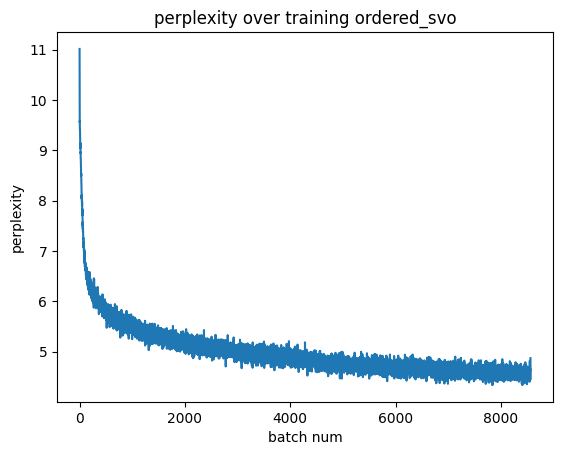

Losses saved to /content/drive/MyDrive/NLP Project/trained_model_ordered_svo_1000000_2/training_losses.json
Evaluate model on validation dataset


100%|██████████| 4290/4290 [11:10<00:00,  6.40it/s]


Average validation loss: 4.553094241557977
Validation losses saved to /content/drive/MyDrive/NLP Project/trained_model_ordered_svo_1000000_2/validation_losses.json
Evaluate model on test dataset


100%|██████████| 4373/4373 [11:25<00:00,  6.38it/s]


Average test loss: 4.630617011528442
Test losses saved to /content/drive/MyDrive/NLP Project/trained_model_ordered_svo_1000000_2/test_losses.json
Training on ordered_vso sentences for 2 epochs


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)
Epoch 1/2


  5%|▌         | 216/4281 [01:36<30:08,  2.25it/s]


KeyboardInterrupt: 

In [10]:
import torch
from transformers import AdamW
from tqdm import tqdm  # for progress bar
import matplotlib.pyplot as plt
from transformers import GPT2Config, GPT2Tokenizer, AutoModelForCausalLM
import json

models = {}
print(f"The possible types of datasets are {possible_orders}")
print(f"The orders we are training on are {orders_to_run}")

for dataset_type in orders_to_run:
    print(f"Training on {dataset_type} sentences for {num_epochs} epochs")
    train_dataloader = dataloaders[dataset_type]['train']

    config = GPT2Config() # config as in the paper
    model = AutoModelForCausalLM.from_config(config)
    print(model)

    model.to(device)

    optimizer = AdamW(model.parameters(), lr=5e-5)
    prompt = None

    losses = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()

        for batch in tqdm(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
        print(f"Loss: {sum(losses[-len(train_dataloader):]) / len(train_dataloader)}")
        print(generate_output(prompt = prompt, model = model, tokenizer = tokenizer))
        save_directory = f"{NLP_folder}/trained_model_{dataset_type}_{n_datapoints}_{num_epochs}"

        # Save the model
        model.save_pretrained(save_directory)
        # Save the tokenizer
        tokenizer.save_pretrained(save_directory)
        print(f"Model and tokenizer saved to {save_directory}")

    print("Training complete!")
    models[dataset_type] = model

    pd.Series(losses).plot(title=f'perplexity over training {dataset_type}', xlabel='batch num', ylabel='perplexity')
    plt.show()

    # Save the losses to a JSON file in the same directory
    losses_file = f"{save_directory}/training_losses.json"
    with open(losses_file, "w") as f:
        json.dump(losses, f)
    print(f"Losses saved to {losses_file}")

    print("Evaluate model on validation dataset")

    # Set model to evaluation mode
    model.eval()

    val_losses = []

    for batch in tqdm(dataloaders[dataset_type]['val']):
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)
            loss = outputs.loss
            val_losses.append(loss.item())

    print(f"Average validation loss: {pd.Series(val_losses).mean()}")

    # Save the validation losses
    val_losses_file = f"{save_directory}/validation_losses.json"
    with open(val_losses_file, "w") as f:
        json.dump(val_losses, f)
    print(f"Validation losses saved to {val_losses_file}")

    print("Evaluate model on test dataset")

    # Calculate test losses
    test_losses = []

    for batch in tqdm(dataloaders[dataset_type]['test']):
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)
            loss = outputs.loss
            test_losses.append(loss.item())
    print(f"Average test loss: {pd.Series(test_losses).mean()}")

    # Save the test losses
    test_losses_file = f"{save_directory}/test_losses.json"
    with open(test_losses_file, "w") as f:
        json.dump(test_losses, f)
    print(f"Test losses saved to {test_losses_file}")

## cluster


```
#!/usr/bin/bash
#SBATCH --job-name=nlp
#SBATCH --output=nlp.%j.out
#SBATCH --error=nlp.%j.err
#SBATCH --time=1-00:00:00
#SBATCH -p serc
SBATCH --gpus=1
#SBATCH --mem-per-cpu=80G
#SBATCH --constraint=GPU_SKU:A100_SXM4

ml python/3.12.1
ml py-pytorch/2.4.1_py312
ml py-pandas/2.2.1_py312
ml py-datasets/2.18.0_py312
ml py-transformers/4.39.1_py312
ml py-matplotlib/3.8.3_py312

python3 train_on_different_orders.py

sh_dev -p serc -g 1 -t 2-00:00:00 -m 80GB
```


python3 train_on_different_orders.py  -n 100000 -r 1 -e 10
